In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    brier_score_loss, precision_score, recall_score, classification_report
)

%matplotlib inline

df_model = pd.read_csv("/content/final_modeling_features_complete.csv")

print("Loaded dataset with shape:", df_model.shape)
df_model.head()

Loaded dataset with shape: (362612, 26)


,grid_id,iso_year,iso_week,crime_count,lag_1,lag_2,avg_2wk,trend_2wk,hotspot,kde_score,...,distinct_offense_count,offense_entropy,off_ASSAULT_3_&_RELATED_OFFENSES,off_CRIMINAL_MISCHIEF_&_RELATED_OF,off_FELONY_ASSAULT,off_GRAND_LARCENY,off_HARRASSMENT_2,off_OFF._AGNST_PUB_ORD_SENSBLTY_&,off_PETIT_LARCENY,off_VEHICLE_AND_TRAFFIC_LAWS
0,G_10_10,2022,5,2,2.0,2.0,2.0,0.0,0,2.035706,...,1,-1.000089e-12,0,0,0,0,2,0,0,0
1,G_10_10,2022,11,2,2.0,2.0,2.0,0.0,0,2.171366,...,2,6.931472e-01,0,0,1,0,0,0,0,0
2,G_10_10,2022,14,1,2.0,2.0,2.0,0.0,0,2.725830,...,1,-1.000089e-12,0,0,0,0,1,0,0,0
3,G_10_10,2022,15,1,1.0,2.0,1.5,-1.0,0,1.375662,...,1,-1.000089e-12,0,0,0,0,1,0,0,0
4,G_10_10,2022,16,1,1.0,1.0,1.0,0.0,0,1.332424,...,1,-1.000089e-12,0,0,0,0,0,1,0,0


In [2]:
y = df_model['hotspot']

feature_cols = [
    'crime_count', 'lag_1', 'lag_2', 'avg_2wk', 'trend_2wk',
    'kde_norm', 'kde_pct',
    'is_cluster', 'was_cluster_prev', 'cluster_age', 'cluster_change',
    'distinct_offense_count', 'offense_entropy',
    'off_ASSAULT_3_&_RELATED_OFFENSES',
    'off_CRIMINAL_MISCHIEF_&_RELATED_OF',
    'off_FELONY_ASSAULT',
    'off_GRAND_LARCENY',
    'off_HARRASSMENT_2',
    'off_OFF._AGNST_PUB_ORD_SENSBLTY_&',
    'off_PETIT_LARCENY',
    'off_VEHICLE_AND_TRAFFIC_LAWS'
]

X = df_model[feature_cols]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

train_mask = df_model['iso_year'] < 2024
test_mask  = df_model['iso_year'] == 2024

X_train = X[train_mask]
X_test  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:",  X_test.shape,  y_test.shape)

Feature matrix shape: (362612, 21)
Target shape: (362612,)
Train shapes: (239440, 21) (239440,)
Test shapes: (122093, 21) (122093,)


In [3]:
print("Initial shapes:", X.shape, y.shape)
n_missing_y = y.isna().sum()
print("Missing labels (y):", n_missing_y)

nan_counts_X = X.isna().sum()
print("\nTop feature NaN counts:")
print(nan_counts_X[nan_counts_X > 0])

mask_valid = (~y.isna()) & (~X.isna().any(axis=1))
print("\nRows valid for modeling:", mask_valid.sum())

X_clean = X[mask_valid].reset_index(drop=True)
y_clean = y[mask_valid].reset_index(drop=True)

df_clean = df_model[mask_valid.values].reset_index(drop=True)

# train: <2024, test: 2024
train_mask = df_clean['iso_year'] < 2024
test_mask  = df_clean['iso_year'] == 2024

X_train = X_clean[train_mask.values]
X_test  = X_clean[test_mask.values]
y_train = y_clean[train_mask.values]
y_test  = y_clean[test_mask.values]

print("\nAfter cleaning - shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining Random Forest on cleaned data...")
rf.fit(X_train, y_train)

print("Calibrating probabilities with Isotonic Regression...")
cal_rf = CalibratedClassifierCV(rf, method='isotonic', cv=3)
cal_rf.fit(X_train, y_train)

y_prob = cal_rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

brier = brier_score_loss(y_test, y_prob)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)

print("\n========== MODEL PERFORMANCE ==========")
print(f"Brier Score: {brier:.6f}")
print(f"Precision:   {prec:.6f}")
print(f"Recall:      {rec:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Initial shapes: (362612, 21) (362612,)
Missing labels (y): 0

Top feature NaN counts:
Series([], dtype: int64)

Rows valid for modeling: 362612

After cleaning - shapes:
X_train: (239440, 21) y_train: (239440,)
X_test : (122093, 21) y_test : (122093,)

Training Random Forest on cleaned data...
Calibrating probabilities with Isotonic Regression...

========== MODEL PERFORMANCE ==========
Brier Score: 0.010337
Precision:   0.884907
Recall:      0.995020

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    108841
           1       0.88      1.00      0.94     13252

    accuracy                           0.99    122093
   macro avg       0.94      0.99      0.96    122093
weighted avg       0.99      0.99      0.99    122093



In [4]:
#Precision@k and PAI (Predictive Accuracy Index)

pred_df = pd.DataFrame({
    'grid_id': df_clean['grid_id'][test_mask.values].values,
    'iso_year': df_clean['iso_year'][test_mask.values].values,
    'iso_week': df_clean['iso_week'][test_mask.values].values,
    'y_true': y_test.values,
    'y_prob': y_prob
})

def precision_at_k(probs, true, k):
    cutoff = np.quantile(probs, 1 - k)
    selected = (probs >= cutoff)
    if selected.sum() == 0:
        return 0
    return true[selected].sum() / selected.sum()

p5  = precision_at_k(pred_df['y_prob'], pred_df['y_true'], 0.05)
p10 = precision_at_k(pred_df['y_prob'], pred_df['y_true'], 0.10)

print(f"Precision@5%  = {p5:.6f}")
print(f"Precision@10% = {p10:.6f}")

captured_5  = pred_df.sort_values('y_prob', ascending=False).head(int(len(pred_df) * 0.05))['y_true'].sum()
captured_10 = pred_df.sort_values('y_prob', ascending=False).head(int(len(pred_df) * 0.10))['y_true'].sum()

total_crimes = pred_df['y_true'].sum()

pai_5  = (captured_5  / total_crimes) / 0.05
pai_10 = (captured_10 / total_crimes) / 0.10

print(f"\nPAI@5%  = {pai_5:.4f}")
print(f"PAI@10% = {pai_10:.4f}")

Precision@5%  = 0.998635
Precision@10% = 0.996234

PAI@5%  = 9.2001
PAI@10% = 9.1782


In [5]:
print("Total test rows:", len(pred_df))
print("Total hotspots in test:", pred_df['y_true'].sum())

k = 0.10
cut = np.quantile(pred_df['y_prob'], 1 - k)
print("10% cutoff probability:", cut)

selected = pred_df['y_prob'] >= cut
print("Rows selected:", selected.sum())

true_hot_in_top10 = pred_df.loc[selected, 'y_true'].sum()
print("Hotspots in top 10%:", true_hot_in_top10)

correct_precision_10 = true_hot_in_top10 / selected.sum()
print("Corrected Precision@10% =", correct_precision_10)

Total test rows: 122093
Total hotspots in test: 13252
10% cutoff probability: 0.9085673743181483
Rows selected: 12214
Hotspots in top 10%: 12168
Corrected Precision@10% = 0.9962338300311119


In [6]:
# using SIGMOID instead of ISOTONIC
print("Training Random Forest (same hyperparameters)...")

rf2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf2.fit(X_train, y_train)

print("Calibrating probabilities with SIGMOID...")
cal_rf2 = CalibratedClassifierCV(rf2, method='sigmoid', cv=3)
cal_rf2.fit(X_train, y_train)

y_prob2 = cal_rf2.predict_proba(X_test)[:, 1]
y_pred2 = (y_prob2 >= 0.5).astype(int)

brier2 = brier_score_loss(y_test, y_prob2)
prec2 = precision_score(y_test, y_pred2)
rec2  = recall_score(y_test, y_pred2)

print("\n========== SIGMOID MODEL PERFORMANCE ==========")
print(f"Brier Score: {brier2:.6f}")
print(f"Precision:   {prec2:.6f}")
print(f"Recall:      {rec2:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

Training Random Forest (same hyperparameters)...
Calibrating probabilities with SIGMOID...

========== SIGMOID MODEL PERFORMANCE ==========
Brier Score: 0.010207
Precision:   0.886118
Recall:      0.994642

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    108841
           1       0.89      0.99      0.94     13252

    accuracy                           0.99    122093
   macro avg       0.94      0.99      0.96    122093
weighted avg       0.99      0.99      0.99    122093



In [7]:
# Precision@k and PAI using SIGMOID-calibrated model

pred_df2 = pd.DataFrame({
    'grid_id': df_clean['grid_id'][test_mask.values].values,
    'iso_year': df_clean['iso_year'][test_mask.values].values,
    'iso_week': df_clean['iso_week'][test_mask.values].values,
    'y_true': y_test.values,
    'y_prob': y_prob2
})

def precision_at_k(probs, true, k):
    cutoff = np.quantile(probs, 1 - k)
    selected = (probs >= cutoff)
    if selected.sum() == 0:
        return 0
    return true[selected].sum() / selected.sum()

p5  = precision_at_k(pred_df2['y_prob'], pred_df2['y_true'], 0.05)
p10 = precision_at_k(pred_df2['y_prob'], pred_df2['y_true'], 0.10)

print(f"Precision@5%  = {p5:.6f}")
print(f"Precision@10% = {p10:.6f}")

captured_5  = pred_df2.sort_values('y_prob', ascending=False).head(int(len(pred_df2) * 0.05))['y_true'].sum()
captured_10 = pred_df2.sort_values('y_prob', ascending=False).head(int(len(pred_df2) * 0.10))['y_true'].sum()

total_crimes = pred_df2['y_true'].sum()

pai_5  = (captured_5  / total_crimes) / 0.05
pai_10 = (captured_10 / total_crimes) / 0.10

print(f"\nPAI@5%  = {pai_5:.4f}")
print(f"PAI@10% = {pai_10:.4f}")

Precision@5%  = 0.999345
Precision@10% = 0.995905

PAI@5%  = 9.2062
PAI@10% = 9.1752


/tmp/ipython-input-501698977.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')


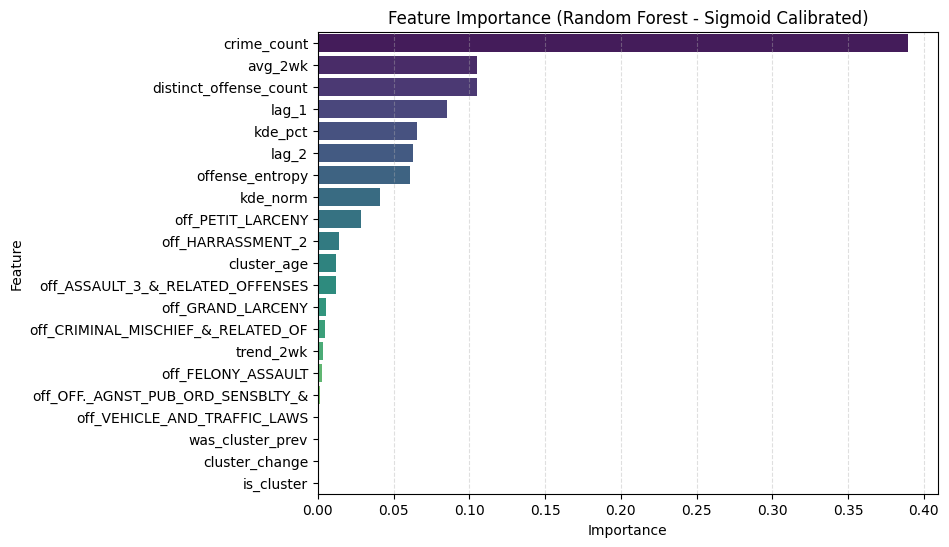

,feature,importance
0,crime_count,3.898434e-01
3,avg_2wk,1.051442e-01
11,distinct_offense_count,1.050432e-01
1,lag_1,8.511224e-02
6,kde_pct,6.545087e-02
2,lag_2,6.254217e-02
12,offense_entropy,6.092264e-02
5,kde_norm,4.069868e-02
19,off_PETIT_LARCENY,2.852015e-02
17,off_HARRASSMENT_2,1.374658e-02


In [8]:
# Feature Importance Bar Plot

import matplotlib.pyplot as plt
import seaborn as sns

rf_fitted = cal_rf2.calibrated_classifiers_[0].estimator
importances = rf_fitted.feature_importances_
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
plt.title("Feature Importance (Random Forest - Sigmoid Calibrated)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

fi_df

In [9]:
pred_output = df_clean[test_mask.values].copy()
pred_output['pred_prob'] = y_prob2
pred_output['pred_label'] = (y_prob2 >= 0.5).astype(int)

pred_path = "/content/predicted_hotspots_2024.csv"
pred_output.to_csv(pred_path, index=False)

print("Saved predictions to:", pred_path)
pred_output.head()

Saved predictions to: /content/predicted_hotspots_2024.csv


,grid_id,iso_year,iso_week,crime_count,lag_1,lag_2,avg_2wk,trend_2wk,hotspot,kde_score,...,off_ASSAULT_3_&_RELATED_OFFENSES,off_CRIMINAL_MISCHIEF_&_RELATED_OF,off_FELONY_ASSAULT,off_GRAND_LARCENY,off_HARRASSMENT_2,off_OFF._AGNST_PUB_ORD_SENSBLTY_&,off_PETIT_LARCENY,off_VEHICLE_AND_TRAFFIC_LAWS,pred_prob,pred_label
54,G_10_10,2024,2,1,3.0,2.0,2.5,1.0,0,0.722332,...,0,0,0,0,0,0,0,0,0.001598,0
55,G_10_10,2024,5,1,1.0,3.0,2.0,-2.0,0,2.495529,...,0,0,0,0,0,1,0,0,0.001598,0
56,G_10_10,2024,6,1,1.0,1.0,1.0,0.0,0,1.171095,...,0,0,0,0,1,0,0,0,0.001598,0
57,G_10_10,2024,7,3,1.0,1.0,1.0,0.0,0,2.363820,...,0,1,0,0,2,0,0,0,0.001598,0
58,G_10_10,2024,8,2,3.0,1.0,2.0,2.0,0,3.495528,...,0,0,0,1,0,1,0,0,0.001598,0


In [11]:
# plot static map and Folium
import folium
from folium.plugins import MarkerCluster, HeatMap

pred_path = "/content/predicted_hotspots_2024.csv"
grid_path = "/content/grid_cells.csv"
pred = pd.read_csv(pred_path)
grid = pd.read_csv(grid_path)

pred_map = pred.merge(grid[['grid_id','centroid_lat','centroid_lon']], on='grid_id', how='left')

pred_map = pred_map.dropna(subset=['centroid_lat','centroid_lon']).reset_index(drop=True)
print("Rows to map:", len(pred_map))

map_csv = "/content/pred_map_2024.csv"
pred_map.to_csv(map_csv, index=False)
print("Saved mapping CSV:", map_csv)

plt.figure(figsize=(8,8))
sc = plt.scatter(pred_map['centroid_lon'], pred_map['centroid_lat'],
                 c=pred_map['pred_prob'], cmap='Reds', s=12, alpha=0.8)
plt.colorbar(sc, label='Predicted hotspot probability')
plt.title("Predicted Hotspot Probabilities (grid centroids) — 2024")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

TOP_N = 300
top_pred = pred_map.sort_values('pred_prob', ascending=False).head(TOP_N)

center_lat = pred_map['centroid_lat'].median()
center_lon = pred_map['centroid_lon'].median()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

mc = MarkerCluster().add_to(m)
for r in top_pred.itertuples():
    prob = float(r.pred_prob)
    folium.CircleMarker(
        location=(r.centroid_lat, r.centroid_lon),
        radius=4 + prob*12,
        color=None,
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"grid: {r.grid_id}<br>prob: {prob:.3f}<br>pred_label: {int(r.pred_label)}"
    ).add_to(mc)

try:
    heat_pts = pred_map[['centroid_lat','centroid_lon','pred_prob']].values.tolist()
    HeatMap(heat_pts, radius=20, blur=15, max_zoom=12).add_to(m)
except Exception as e:
    print("HeatMap skipped:", e)

html_path = "/content/predicted_hotspots_map_2024.html"
m.save(html_path)
print("Saved Folium map HTML:", html_path)

m

Output hidden; open in https://colab.research.google.com to view.

In [12]:
from pathlib import Path

files_to_check = {
    'final_model_sigmoid': "/content/calibrated_rf_sigmoid.joblib",
    'final_rf_base'      : "/content/rf_base.joblib",
    'predictions_csv'    : "/content/predicted_hotspots_2024.csv",
    'pred_map_csv'       : "/content/pred_map_2024.csv",
    'folium_map_html'    : "/content/predicted_hotspots_map_2024.html",
    'final_features'     : "/content/final_modeling_features_complete.csv"
}

try:
    joblib.dump(cal_rf2, files_to_check['final_model_sigmoid'])
    joblib.dump(rf2, files_to_check['final_rf_base'])
    saved_models = True
except Exception as e:
    print("Model save error:", e)
    saved_models = False

for k, p in files_to_check.items():
    exists = Path(p).exists()
    print(f"{k:20s}: {'FOUND' if exists else 'MISSING':7s}   {p if exists else ''}")
    if exists:
        print("  size(bytes):", Path(p).stat().st_size)

print("\n=== Final model metrics (sigmoid-calibrated) ===")
try:
    print(f"Brier Score: {brier2:.6f}")
    print(f"Precision:   {prec2:.6f}")
    print(f"Recall:      {rec2:.6f}")
except NameError:
    print("Metrics not found in session (run evaluation cells first).")

print("\n=== Quick checklist ===")
print("- Final modeling CSV:", files_to_check['final_features'])
print("- Predictions CSV:", files_to_check['predictions_csv'])
print("- Interactive map HTML:", files_to_check['folium_map_html'])
print("- Saved calibrated model:", files_to_check['final_model_sigmoid'] if saved_models else "NOT SAVED")

Model save error: name 'joblib' is not defined
final_model_sigmoid : MISSING   
final_rf_base       : MISSING   
predictions_csv     : FOUND     /content/predicted_hotspots_2024.csv
  size(bytes): 20027687
pred_map_csv        : FOUND     /content/pred_map_2024.csv
  size(bytes): 24241236
folium_map_html     : FOUND     /content/predicted_hotspots_map_2024.html
  size(bytes): 7778262
final_features      : FOUND     /content/final_modeling_features_complete.csv
  size(bytes): 50819719

=== Final model metrics (sigmoid-calibrated) ===
Brier Score: 0.010207
Precision:   0.886118
Recall:      0.994642

=== Quick checklist ===
- Final modeling CSV: /content/final_modeling_features_complete.csv
- Predictions CSV: /content/predicted_hotspots_2024.csv
- Interactive map HTML: /content/predicted_hotspots_map_2024.html
- Saved calibrated model: NOT SAVED
